In [241]:
from pandas import Series
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [245]:
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')

#сразу объёдиним датасеты, добавив sample
train_csv['sample'] = 1   
test_csv['sample'] = 0    
test_csv['default'] = -1  
df = train_csv.append(test_csv, sort=False).reset_index(drop=True)

In [246]:
#report = ProfileReport(df, title="Pandas Profiling Report")
#report

# Посмотрим что у нас изменилось в новом датасете
## новые параметры:
- `sna` - категориальный (уже числа)
- `first_time` - категориальный (уже числа)
- `score_bki` - числовой, нормально распределён, без пропусков, но средняя странно сдвинута
- `region_rating` - числовой, но ступенчатый как range(20,80,20), примерно норм. распределён
- `app_date` - datatime но в другом формате.

## старые:
- `education` - по прежнему есть пропуски

In [247]:
# Разделим на типы
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating']

In [248]:
# чтобы видеть их на графиках дадим им какой-то стринг
df = df.fillna(value={'education':'None'})

<AxesSubplot:title={'center':'income'}, xlabel='[education]'>

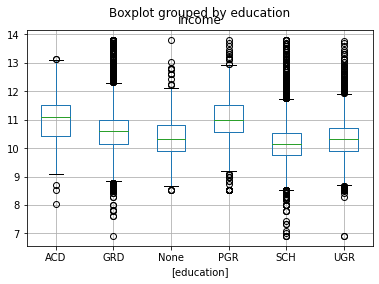

In [249]:
# интересно как завист доход от образования
# чтобы выло нагляднее, сразу логарифмируем зп
df['income'] = df['income'].apply(lambda w: np.log(w + 1))
df.boxplot(column='income', by = ['education'])

`средняя между SCH и GRD`

In [252]:
print(train_csv['education'].isnull().value_counts())
print(test_csv['education'].isnull().value_counts())

False    73492
True       307
Name: education, dtype: int64
False    36178
True       171
Name: education, dtype: int64


`Такие пропустки есть и в тестовой выборке`

<AxesSubplot:>

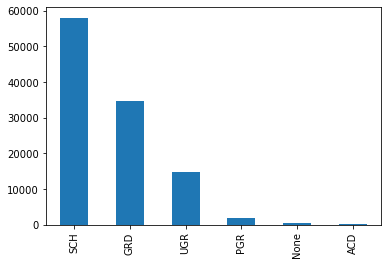

In [253]:
df['education'].value_counts().plot.bar()

`но они встречаются редко, заменим их на самый распространённый`

In [254]:
# закодируем их вручную 
edu = {"SCH": 1, "GRD": 3, "UGR": 2, "PGR": 4, "None": 1, "ACD": 5}
df['education'] = df['education'].replace(edu)   

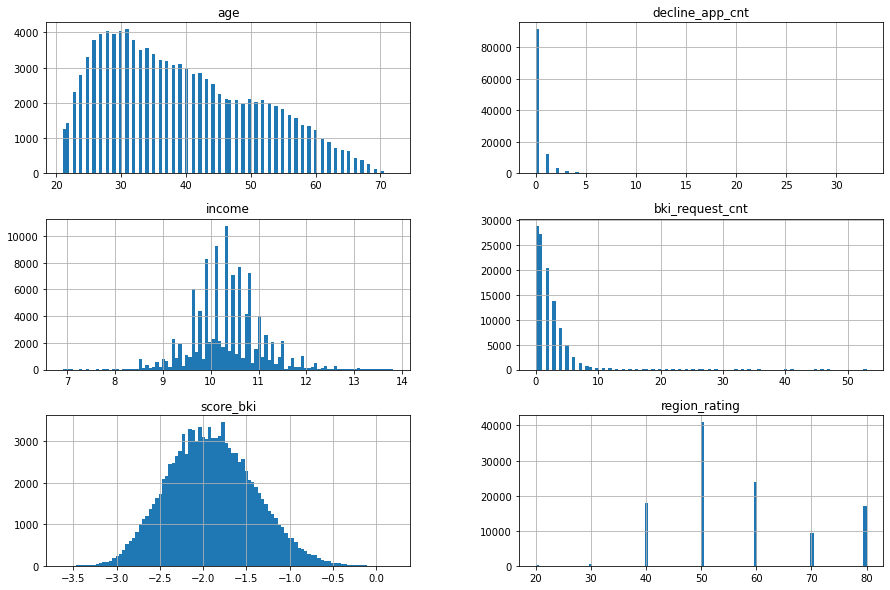

In [255]:
df[num_cols].hist(figsize=(15, 10), bins=100);

In [256]:
# вместо того чтобы убирать выбросы в признаках с вытянутыми хвостами, прологарифмируем их
for i in ['decline_app_cnt', 'bki_request_cnt']:
    df[i] = df[i].apply(lambda w: np.log(w + 1))

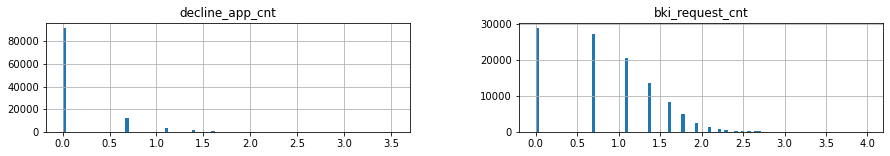

In [257]:
df[['decline_app_cnt', 'bki_request_cnt']].hist(figsize=(15,2), bins=100);

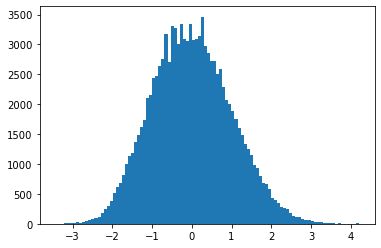

In [258]:
# Стандартизация числовых переменных
X_num_test = StandardScaler().fit_transform(df[['age','score_bki']].values)
plt.hist(X_num_test[:,1:].T[0], bins=100);

<AxesSubplot:>

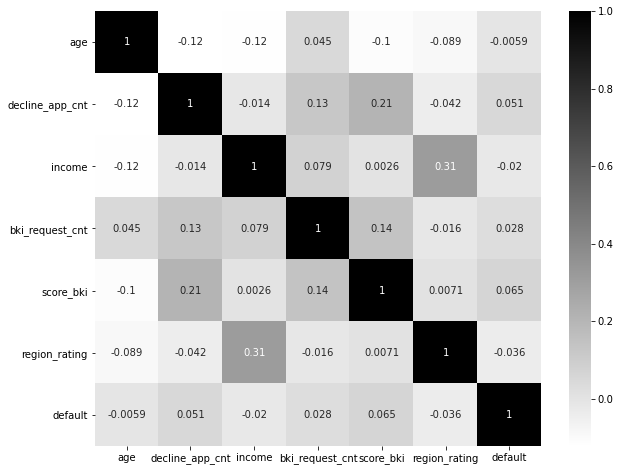

In [259]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols+['default']].corr(), cmap='gray_r', annot=True)
#sns.heatmap(df[num_cols].corr(), cmap='gray_r', annot=True)

`на корреляцию с default смотреть тут бессмысленно, т.к. она вместе с тестовой склеена где default -1`

`рейтинг района и зп самые коррелируемые между собой, но не настолько чтобы один удалять`

## Оценку значимости оставим, интересно посмотреть насколько значимы новые добавленные признаки

Смотрим оценки только на train части датасета, т.к. в тестовом нет целевой переменной

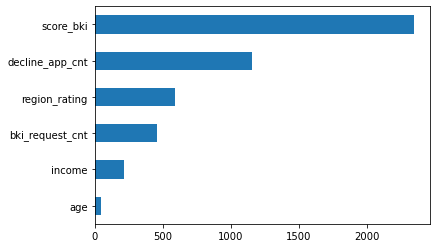

In [260]:
tr_part = df[ df['sample']==1 ]
#tr_part
imp_num = pd.Series(f_classif(tr_part[num_cols], tr_part['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

`как раз score_bki и имеет наивысшую значимость, он то у улучшит все метрики в итоге`

In [261]:
# закодируем бинарные переменные
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

<AxesSubplot:>

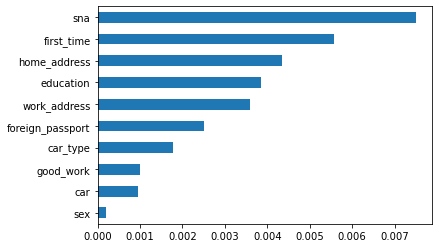

In [262]:
tr_part = df[ df['sample']==1 ]
imp_cat = Series(mutual_info_classif(tr_part[bin_cols + cat_cols], tr_part['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

`sna оказался тоже очень значимым признаком`

In [263]:
# категоральные переменные закодируем по старинке с помощью get_dummies
# X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
# X_cat.shape
df = pd.get_dummies(df, columns=cat_cols)

In [264]:
# Стандартизация числовых переменных только для score_bki
num_cols_std = ['score_bki']
num_cols_wo_std = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'region_rating']
df[num_cols_std] = StandardScaler().fit_transform(df[num_cols_std].values)

In [265]:
df

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,01FEB2014,1,62,1,1,0.000000,0,-0.208688,0.693147,...,1,0,0,0,0,1,1,0,0,0
1,63161,12MAR2014,0,59,0,0,0.000000,0,0.745419,1.386294,...,0,1,0,0,0,1,1,0,0,0
2,25887,01FEB2014,1,25,1,0,1.098612,0,0.993988,0.693147,...,1,0,1,0,0,0,0,0,0,1
3,16222,23JAN2014,0,53,0,0,0.000000,0,-0.306243,1.098612,...,0,1,1,0,0,0,0,0,1,0
4,101655,18APR2014,1,48,0,0,0.000000,1,1.321223,0.693147,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,0,37,0,0,0.693147,0,0.319505,1.386294,...,0,1,0,0,0,1,1,0,0,0
110144,106254,25APR2014,0,64,1,1,0.000000,0,-0.779436,1.386294,...,1,0,1,0,0,0,0,0,0,1
110145,81852,30MAR2014,1,31,0,0,1.098612,0,1.929901,0.693147,...,1,0,0,0,0,1,0,1,0,0
110146,1971,07JAN2014,0,27,0,0,0.693147,0,1.325890,1.098612,...,0,1,1,0,0,0,1,0,0,0


In [266]:
# пока просто дропним
df = df.drop(['app_date'], axis=1)

In [267]:
# Разделим обратно на train и test
train = df.query('sample == 1').drop(['sample'], axis=1)
test = df.query('sample == 0').drop(['sample'], axis=1)
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42, test_size=0.2)

# Обучаем

acc = 0.8752 F1-score = 0.0396


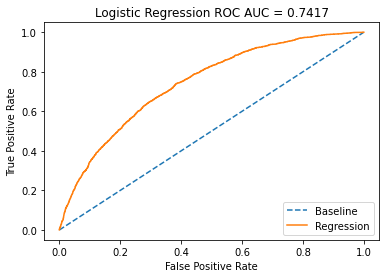

In [268]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'acc = {acc:.4f} F1-score = {f1:.4f}')

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [242]:
#подбор гиперпараметров модели
model = LogisticRegression(max_iter = 1000, random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
#печатаем параметры
best_parameters = model.get_params()
print(best_parameters)

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# Повторим уже с регуляризацией

acc = 0.6675 F1-score = 0.3369


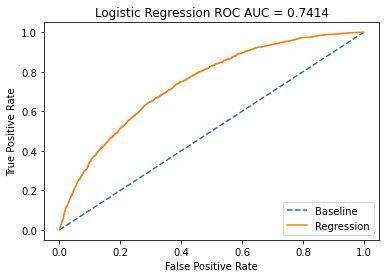

In [280]:
model_r = LogisticRegression(**best_parameters)
model_r.fit(X_train, y_train)

probs = model_r.predict_proba(X_test)
probs = probs[:,1]

y_pred = model_r.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'acc = {acc:.4f} F1-score = {f1:.4f}')

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### после регуляризации
- `roc auc` не очень поменялся
- `acc` и `f1-score` сильно поменялись

# Подготовка submission

In [281]:
X = test.drop(columns = ['default', 'client_id'])
# итоговая с регуляризаций оказалась лучше на тестовой выборке на kaggle
# predict_submission = model.predict_proba(X)
predict_submission = model_r.predict_proba(X)
probs = predict_submission[:, 1]
test_csv['default'] = predict_submission[:, 1]
submission = test_csv[['client_id', 'default']]
submission.to_csv('./data/submission1.csv', index=False)

In [282]:
submission

,client_id,default
0,74835,0.229378
1,17527,0.784309
2,75683,0.333497
3,26883,0.394041
4,28862,0.130250
...,...,...
36344,83775,0.793238
36345,106254,0.125903
36346,81852,0.814954
36347,1971,0.584679
